# Convolutional Transformer Comparison - no aug no samp vs light augmentation and oversampling

Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


KeyboardInterrupt: 

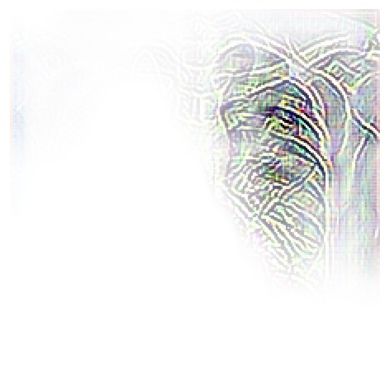

In [3]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
from libraries.bcosconv2d import NormedConv2d
import pydicom 
import random
import matplotlib.pyplot as plt

from collections import OrderedDict

from libraries.bcosconv2d import NormedConv2d
from libraries.bcoslinear import BcosLinear
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d

from libraries import augmentations



np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Paths
csv_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"

#csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"
model_path_worse = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos\no_nosamp_norm\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos\light_oversamp_norm\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_worse = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model_worse.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_worse = torch.load(model_path_worse, map_location=device)

model_worse.load_state_dict(state_dict_worse)
model_worse = model_worse.to(device)
model_worse.eval()

# Load model
model_better = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model_better.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_better = torch.load(model_path_better, map_location=device)

model_better.load_state_dict(state_dict_better)
model_better = model_better.to(device)
model_better.eval()


# Transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Normalize with ImageNet stats
    ])

data = pd.read_csv(csv_path)
first_split = splits[0]
val_idx = first_split[1]  # Only use the validation indices from the 5th split
val_data = data.iloc[val_idx]
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


directory = r"C:\Users\Admin\Documents\MasterThesis\comparison_images\Test"
os.makedirs(directory, exist_ok=True)


i = 0
with torch.no_grad():
    for images, labels, patient_ids in val_loader:
        images, labels = images.to(device), labels.to(device)
        six_channel_images = []
        if i > 50:
            break
        for img_tensor in images:
            numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            pil_image = Image.fromarray(numpy_image)
            transformed_image = model_worse.transform(pil_image)
            six_channel_images.append(transformed_image)
        six_channel_images = torch.stack(six_channel_images).to(device)
        outputs = model_worse(six_channel_images)  # Logits
        probs = torch.softmax(outputs, dim=1)  # Probabilities
        preds = torch.argmax(probs, dim=1)  # Binary predictions
        for image, patient_id in zip(six_channel_images, patient_ids):
          i += 1
          if i > 50:
            break
          image = image[None]
          expl_worse = model_worse.explain(image)
          filename = f"{patient_id}_worse_explanation.png"
          image_path_worse = os.path.join(directory, filename)

          plt.figure()
          plt.imshow(expl_worse["explanation"])
          plt.axis('off')
          plt.savefig(image_path_worse, bbox_inches="tight", pad_inches=0)
          plt.close()
        
        
          expl_better = model_better.explain(image)
          filename = f"{patient_id}_better_explanation.png"
          image_path = os.path.join(directory, filename)

          
          plt.figure()
          plt.imshow(expl_better["explanation"])
          plt.axis('off')
          plt.savefig(image_path, bbox_inches="tight", pad_inches=0)
          plt.close()


# ResNet50 Comparison

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
from libraries.bcosconv2d import NormedConv2d
import pydicom 
import random
import matplotlib.pyplot as plt

from collections import OrderedDict

from libraries.bcosconv2d import NormedConv2d
from libraries.bcoslinear import BcosLinear
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Paths
csv_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"

#csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"
model_path_worse = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos\no_nosamp_nonorm\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos\light_oversamp_nonorm\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_worse = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model_worse.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_worse = torch.load(model_path_worse, map_location=device)

model_worse.load_state_dict(state_dict_worse)
model_worse = model_worse.to(device)
model_worse.eval()

# Load model
model_better = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model_better.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_better = torch.load(model_path_better, map_location=device)

model_better.load_state_dict(state_dict_better)
model_better = model_better.to(device)
model_better.eval()


# Transformations
transform = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize([0.490, 0.490, 0.490], [0.248, 0.248, 0.248])
])

data = pd.read_csv(csv_path)
first_split = splits[0]
val_idx = first_split[1]  # Only use the validation indices from the 5th split
val_data = data.iloc[val_idx]
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


directory = r"C:\Users\Admin\Documents\MasterThesis\comparison_images\ResNet50_No_Normalizations"
os.makedirs(directory, exist_ok=True)


i = 0
with torch.no_grad():
    for images, labels, patient_ids in val_loader:
        labels = labels.to(device)
        six_channel_images = []
        if i > 100:
            break   
        for img_tensor in images:
            numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            pil_image = Image.fromarray(numpy_image)
            transformed_image = model_worse.transform(pil_image)
            six_channel_images.append(transformed_image)
        six_channel_images = torch.stack(six_channel_images).to(device)
        for image, patient_id in zip(six_channel_images, patient_ids):
          i += 1
          if i > 100:
            break
          image = image[None]
          expl_worse = model_worse.explain(image)
          filename = f"{patient_id}_worse_explanation.png"
          image_path_worse = os.path.join(directory, filename)

          plt.figure()
          plt.imshow(expl_worse["explanation"])
          plt.axis('off')
          plt.savefig(image_path_worse, bbox_inches="tight", pad_inches=0)
          plt.close()
        
        
          expl_better = model_better.explain(image)
          filename = f"{patient_id}_better_explanation.png"
          image_path = os.path.join(directory, filename)

          
          plt.figure()
          plt.imshow(expl_better["explanation"])
          plt.axis('off')
          plt.savefig(image_path, bbox_inches="tight", pad_inches=0)
          plt.close()


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


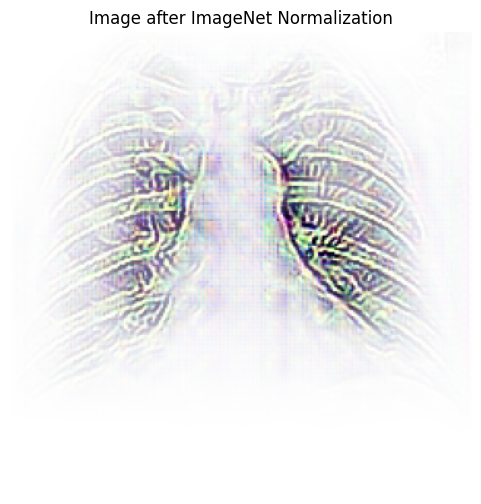

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = r"C:\Users\Admin\Documents\MasterThesis\comparison_images\FLCWithHammingWindow_reslow\01a5594f-e5d4-4f7a-b79d-3f57559fe37b_normal_explanation.png"  # Replace with your file path
image = Image.open(image_path).convert("RGB")

# Convert to NumPy array and normalize
image_np = np.array(image).astype(np.float32) / 255.0  # Scale to [0,1]

# ImageNet normalization values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Apply normalization
normalized_image_np = (image_np - mean) / std

# Convert back for visualization
denormalized_image_np = (normalized_image_np * std) + mean
denormalized_image_np = np.clip(denormalized_image_np, 0, 1)

# Display the processed image
plt.figure(figsize=(6, 6))
plt.imshow(denormalized_image_np)
plt.axis("off")
plt.title("Image after ImageNet Normalization")
plt.show()
